In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections.abc import Callable

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

from teren.config import ExperimentConfig, Reference
from teren.perturbations import (
    NaiveRandomPerturbation,
    RandomPerturbation,
    RandomActivationPerturbation,
    SAEDecoderDirectionPerturbation,
    run_perturbation
)
from teren.utils import (
    generate_prompt,
    load_pretokenized_dataset,
    set_seed,
    get_device_str,
    set_seed
)

In [3]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, np.pi),
    n_steps=361,
    mean_batch_size=700,
)

In [4]:
set_seed(cfg.seed)

In [5]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [7]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [36]:
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [37]:
print(base_prompt)

tensor([[  284, 21873,  6447,   416,  1605,  2056,   546,  2428, 13891,  3298]])


In [42]:
import random

rng = random.Random(cfg.seed)

In [43]:
rng.randint(0,100)

81

In [14]:
# Some experiment specific utils for converting a cov matrix
# to positive definite (we suspect it's because of smaller 
# batch size) needed for MultivariateNormal
def is_positive_definite(A):
    try:
        torch.linalg.cholesky(A)
        return True
    except RuntimeError:
        return False

def nearest_positive_definite(A):
    B = (A + A.T) / 2
    _, s, V = torch.svd(B)
    H = V.mm(torch.diag(s).mm(V.T))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if is_positive_definite(A3):
        return A3
    spacing = np.geomspace(torch.finfo(A.dtype).eps, 1, 10)
    for i in range(len(spacing)):
        mineig = torch.min(torch.real(torch.linalg.eigvals(A3)))
        A3 += torch.eye(A.shape[0]) * (-mineig * (1 + spacing[i]))
        if is_positive_definite(A3):
            return A3
    return A3



In [15]:
batch_of_prompts = generate_prompt(dataset, n_ctx=cfg.n_ctx, batch=cfg.mean_batch_size)
batch_act_cache = model.run_with_cache(batch_of_prompts)[1].to("cpu")
data = batch_act_cache[cfg.perturbation_layer][:, cfg.perturbation_pos, :].squeeze(1)
print(data.shape)
data_mean = data.mean(dim=0, keepdim=True)
data_cov = (
    torch.einsum("i j, i k -> j k", data - data_mean, data - data_mean) / data.shape[0]
)


torch.Size([700, 768])


In [16]:
# substitute covariance matrix with nearest that is positive definite
if not is_positive_definite(data_cov):
    data_cov = nearest_positive_definite(data_cov)

In [17]:
sae = get_gpt2_res_jb_saes(cfg.perturbation_layer)[0][cfg.perturbation_layer].to("cpu")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


In [18]:
unrelated_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
unrelated_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [19]:
# Perturbations
naive_random_perturbation = NaiveRandomPerturbation()
random_perturbation = RandomPerturbation(data_mean, data_cov)
random_activation_perturbation = RandomActivationPerturbation(base_ref, dataset)
saedir_perturbation = SAEDecoderDirectionPerturbation(base_ref, unrelated_ref, sae, negate=-1, thresh=0.1)

perturbations = {
    "naive random direction": naive_random_perturbation,
    "random direction": random_perturbation,
    "direction to random other activation": random_activation_perturbation,
    "direction of negative active SAE decoder feature": saedir_perturbation
}

Using active features: tensor([16815, 21473, 21958, 24149])


In [34]:
results = defaultdict(list)

for _ in tqdm(range(10)):
    for name, perturbation in perturbations.items():
        kl_div = run_perturbation(cfg, base_ref, perturbation)
        results[name].append(kl_div)


100%|██████████| 10/10 [00:59<00:00,  5.98s/it]


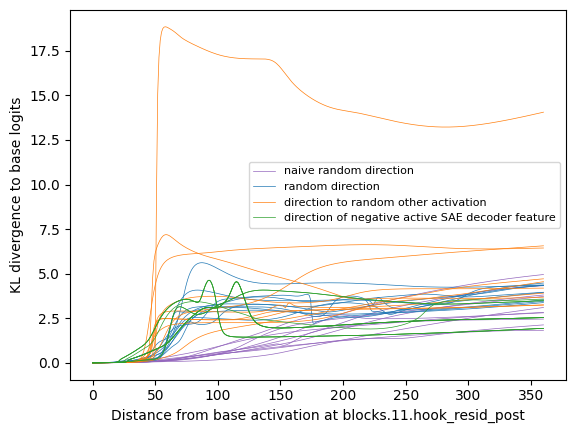

In [35]:
colors = {
    "random direction": "tab:blue",
    "naive random direction": "tab:purple",
    "direction to random other activation": "tab:orange",
    "direction of negative active SAE decoder feature": "tab:green"
}

for perturb_name in results.keys():
    for i, data in enumerate(results[perturb_name]):
        if i == 0:
            # Only label the first line for each perturb_name
            plt.plot(data, color=colors[perturb_name], label=perturb_name, linewidth=0.5)
        else:
            # Don't label subsequent lines to avoid duplicate legend entries
            plt.plot(data, color=colors[perturb_name], linewidth=0.5)

plt.legend(fontsize=8)
plt.ylabel("KL divergence to base logits")
plt.xlabel(f"Distance from base activation at {cfg.read_layer}")
plt.show()

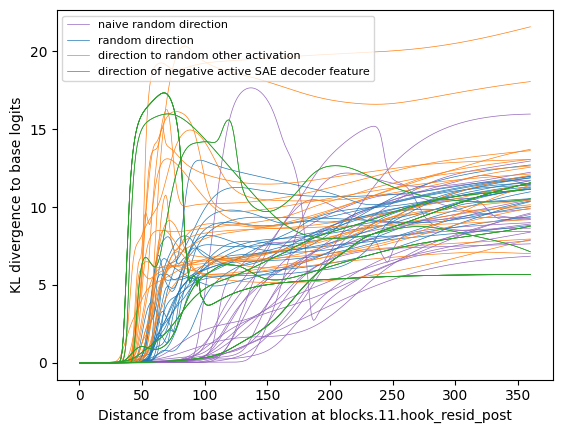

In [18]:
# 20 features, only > 0.1 * max
colors = {
    "random direction": "tab:blue",
    "naive random direction": "tab:purple",
    "direction to random other activation": "tab:orange",
    "direction of negative active SAE decoder feature": "tab:green"
}

for perturb_name in results.keys():
    for i, data in enumerate(results[perturb_name]):
        if i == 0:
            # Only label the first line for each perturb_name
            plt.plot(data, color=colors[perturb_name], label=perturb_name, linewidth=0.5)
        else:
            # Don't label subsequent lines to avoid duplicate legend entries
            plt.plot(data, color=colors[perturb_name], linewidth=0.5)

plt.legend(fontsize=8)
plt.ylabel("KL divergence to base logits")
plt.xlabel(f"Distance from base activation at {cfg.read_layer}")
plt.show()